# Force analysis of ActuAtor

Summary of protocol for estimating forces on the membrane. Nuclei were traced from the EM images manually using Fiji. Assuming the Helfrich-Canham-Evans and surface energy of the membrane,

$$E =  \underbrace{\int_\Omega \kappa_b H^2 dA}_{E_b} + \underbrace{\int_\Omega \sigma dA}_{E_\sigma},$$

where $\kappa_b$ is the bending modulus, $H$ is the mean curvature given by the two principal curvatures, $(k_1 + k_2)/2$,  $\sigma$ is the prescribed constant surface tension, and $dA$ the area element. Given that the segmented EM images are plane curves, we assume naively that the out of plane principal curvature is naught ($k_2 = 0$). Rewriting as an energy density (per length) and simplifying,

$$\frac{E_b}{l} =\frac{\kappa_b}{4} \int_C k_1^2 ds,$$

and 

$$\frac{E_\sigma}{l} =  \sigma \int_C ds,$$ 


where $l$ is the depth relating the integrals over area, $\Omega$, and the plane curve, $C$; $ds$ is the arc-length element. To obtain the areal force density $f$ such that $f ds = -\nabla (E/l)$, we use automatic differentiation using `jax`. Note that $f$ is independent of the length scale $l$.  

## Analysis

In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import math
from collections import defaultdict
from functools import partial
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from jax import jit
from PIL import Image
from scipy.interpolate import splev, splprep
from tqdm.notebook import tqdm

import automembrane.util as u
from automembrane.energy import *

u.matplotlibStyle(small=10, medium=12, large=14)

# List of segmentations as Paths
files = list(
    map(
        Path,
        [
            f"coordinates/{i}"
            for i in [
                "cell1/34D-grid2-s3-acta1_001_16.txt",
                "cell2/34D-grid3-ActA1_007_16.txt",
                "cell2/34D-grid3-ActA1_013_16.txt",
                "cell3/34D-grid2-s2_002_16.txt",
                "cell3/34D-grid2-s5_005_16.txt",
                "cell3/34D-grid3-ActA1_020_16.txt",
                "cell3/34D-grid3-s6_005_16.txt",
                "cell4/34D-grid2-s3_028_16.txt",
                "cell5/34D-grid3-ActA1_001_16.txt",
                "cell5/34D-grid3-ActA1_002_16.txt",
                "cell5/34D-grid3-ActA1_003_16.txt",
                "cell5/34D-grid3-ActA1_004_16.txt",
            ]
        ],
    )
)

# Map of image key to microns per pixel
images = {
    "34D-grid2-s3-acta1_001_16": 0.012723,
    "34D-grid3-ActA1_007_16": 0.015904,
    "34D-grid3-ActA1_013_16": 0.015904,
    "34D-grid2-s2_002_16": 0.015904,
    "34D-grid2-s5_005_16": 0.015904,
    "34D-grid3-ActA1_020_16": 0.015904,
    "34D-grid3-s6_005_16": 0.015904,
    "34D-grid2-s3_028_16": 0.015904,
    "34D-grid3-ActA1_001_16": 0.015904,
    "34D-grid3-ActA1_002_16": 0.015904,
    "34D-grid3-ActA1_003_16": 0.015904,
    "34D-grid3-ActA1_004_16": 0.015904,
}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Assuming bending modulus $1\times10^{-19}$ J and modest membrane tension $0.05$ mN/m.

In [20]:
parameters = {
    "Kb": 0.1 / 4,  # Bending modulus (pN um; original 1e-19 J)
    "Ksg": 50,  # Global stretching modulus (pN um/um^2; original 0.05 mN/m)
    "Ksl": 1,
}

f_energy = partial(get_energy_2d_closed, **parameters)
f_force = partial(get_force_2d_closed, **parameters)

# from automembrane.energy import _get_energy_2d_closed, _get_force_2d_closed
# f_value_and_grad = jax.jit(jax.value_and_grad(partial(_get_energy_2d_closed, **parameters)))


In [21]:
## Benchmarking playground
coords = np.loadtxt(files[0])
coords = np.vstack((coords, coords[0]))

# print(f_energy(coords))
# print(sum(f_force(coords)))

# # %timeit f_energy(coords).block_until_ready()
# # %timeit f_energy_compiled(coords).block_until_ready()
# # %timeit get_energy_2d_closed_notrace(coords)

# # %timeit f_force(coords).block_until_ready()
# # %timeit f_force_compiled(coords).block_until_ready()


We iterate over the segmentations. To ensure that the discrete curves are sufficiently sampled, we parameterize the curve using a B-spline and resample evenly. We perform `n_iter` steps of forward Euler energy relaxation to smooth out artifacts of the discretization. We choose the sum of half the length of each incident edge to be the dual length, $ds_i$, of the $i^{\text{th}}$ vertex, $v_i$.

In [22]:
# n_vertices = 800  # Number of vertices in resampling
target_edge_length = 0.05  # target edge length in um for resampling

total_time = 0.005
dt = 5e-6  # Timestep
n_iter = math.floor(total_time / dt)  # Number of relaxation steps
energy_log = np.zeros(n_iter)
data = defaultdict(dict)

for file in files:
    k = file.stem

    print("Processing:", k)
    original_coords = np.loadtxt(file)
    original_coords = np.vstack(
        (original_coords, original_coords[0])
    )  # Energy expects last point to equal first
    data[k]["original_coords"] = original_coords

    total_length = np.sum(
        np.linalg.norm(
            np.roll(original_coords[:-1], -1, axis=0) - original_coords[:-1], axis=1
        )
    )

    n_vertices = math.floor(total_length / target_edge_length)
    print(f"  Resampling to {n_vertices} vertices")
    # Periodic cubic B-spline interpolation with no smoothing (s=0)
    tck, _ = splprep([original_coords[:, 0], original_coords[:, 1]], s=0, per=True)
    data[k]["spline"] = tck

    xi, yi = splev(np.linspace(0, 1, n_vertices), tck)
    coords = np.hstack((xi.reshape(-1, 1), yi.reshape(-1, 1)))

    # Perform energy relaxation
    relaxed_coords = coords
    if n_iter > 0:
        for i in tqdm(range(0, n_iter), desc="Energy relaxation"):
            # energy, force = f_value_and_grad(relaxed_coords)
            energy_log[i] = sum(f_energy(relaxed_coords))

            relaxed_coords = np.array(
                relaxed_coords - sum(f_force(relaxed_coords)) * dt
            )
            relaxed_coords[-1] = relaxed_coords[0]
            # if (
            #     np.abs(energy_log[i] - energy_log[i - 1]) / energy_log[i - 1] < 1e-7
            #     and i > 0
            # ):
            #     print(
            #         f"step {i} ENERGY CHANGED BY LESS THAN CRITERIA, {np.abs(energy_log[i] - energy_log[i - 1]) / energy_log[i - 1]}"
            #     )
            #     break

        print(
            f"  DELTA E: {energy_log[-1] - energy_log[0]}; E_before: {energy_log[0]}; E_after: {energy_log[-1]}"
        )
    data[k]["relaxed_coords"] = relaxed_coords

    # be, se = get_energy_2d_closed_notrace(relaxed_coords, **parameters)
    # print(f"  Bending Energy: {be:0.2f}; Stretching Energy: {se:0.2f}")

    # Compute dual length
    dc = np.roll(relaxed_coords[:-1], -1, axis=0) - relaxed_coords[:-1]
    edgeLengths = np.linalg.norm(dc, axis=1)
    dualLengths = ((edgeLengths + np.roll(edgeLengths, 1)) / 2.0).reshape(-1, 1)
    dualLengths = np.vstack((dualLengths, dualLengths[0]))
    data[k]["dualLengths"] = dualLengths

    data[k]["relaxed_forces"] = -sum(f_force(relaxed_coords)) / dualLengths


Processing: 34D-grid2-s3-acta1_001_16
  Resampling to 1151 vertices


Energy relaxation:   0%|          | 0/999 [00:00<?, ?it/s]

  DELTA E: -50.7705078125; E_before: 2892.340087890625; E_after: 2841.569580078125
Processing: 34D-grid3-ActA1_007_16
  Resampling to 872 vertices


Energy relaxation:   0%|          | 0/999 [00:00<?, ?it/s]

  DELTA E: -35.6240234375; E_before: 2190.97509765625; E_after: 2155.35107421875
Processing: 34D-grid3-ActA1_013_16
  Resampling to 846 vertices


Energy relaxation:   0%|          | 0/999 [00:00<?, ?it/s]

  DELTA E: -51.392578125; E_before: 2131.041259765625; E_after: 2079.648681640625
Processing: 34D-grid2-s2_002_16
  Resampling to 1035 vertices


Energy relaxation:   0%|          | 0/999 [00:00<?, ?it/s]

  DELTA E: -122.377685546875; E_before: 2618.244384765625; E_after: 2495.86669921875
Processing: 34D-grid2-s5_005_16
  Resampling to 1107 vertices


Energy relaxation:   0%|          | 0/999 [00:00<?, ?it/s]

  DELTA E: -151.775146484375; E_before: 2804.262939453125; E_after: 2652.48779296875
Processing: 34D-grid3-ActA1_020_16
  Resampling to 1046 vertices


Energy relaxation:   0%|          | 0/999 [00:00<?, ?it/s]

  DELTA E: -81.49853515625; E_before: 2636.06298828125; E_after: 2554.564453125
Processing: 34D-grid3-s6_005_16
  Resampling to 914 vertices


Energy relaxation:   0%|          | 0/999 [00:00<?, ?it/s]

  DELTA E: -61.546142578125; E_before: 2302.91943359375; E_after: 2241.373291015625
Processing: 34D-grid2-s3_028_16
  Resampling to 838 vertices


Energy relaxation:   0%|          | 0/999 [00:00<?, ?it/s]

  DELTA E: -54.895263671875; E_before: 2109.5234375; E_after: 2054.628173828125
Processing: 34D-grid3-ActA1_001_16
  Resampling to 828 vertices


Energy relaxation:   0%|          | 0/999 [00:00<?, ?it/s]

  DELTA E: -52.1602783203125; E_before: 2087.1455078125; E_after: 2034.9852294921875
Processing: 34D-grid3-ActA1_002_16
  Resampling to 767 vertices


Energy relaxation:   0%|          | 0/999 [00:00<?, ?it/s]

  DELTA E: -53.12939453125; E_before: 1930.121337890625; E_after: 1876.991943359375
Processing: 34D-grid3-ActA1_003_16
  Resampling to 839 vertices


Energy relaxation:   0%|          | 0/999 [00:00<?, ?it/s]

  DELTA E: -44.37646484375; E_before: 2110.65478515625; E_after: 2066.2783203125
Processing: 34D-grid3-ActA1_004_16
  Resampling to 830 vertices


Energy relaxation:   0%|          | 0/999 [00:00<?, ?it/s]

  DELTA E: -39.651123046875; E_before: 2086.820556640625; E_after: 2047.16943359375


Processing 34D-grid2-s3-acta1_001_16


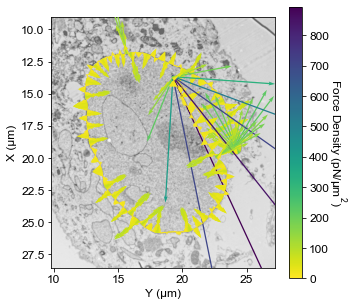

Processing 34D-grid3-ActA1_007_16


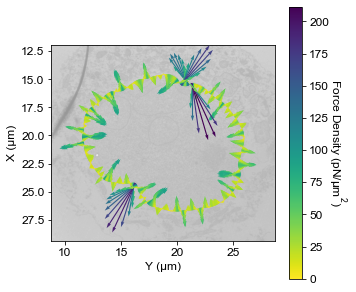

Processing 34D-grid3-ActA1_013_16


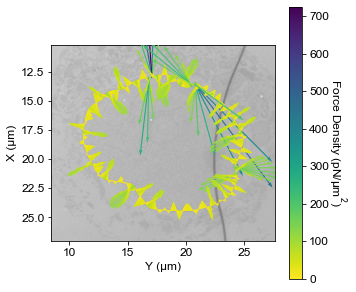

Processing 34D-grid2-s2_002_16


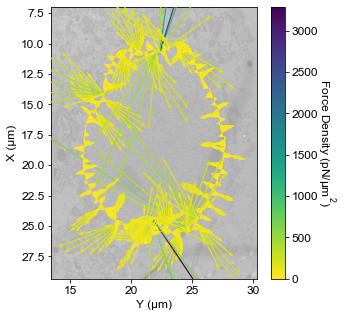

Processing 34D-grid2-s5_005_16


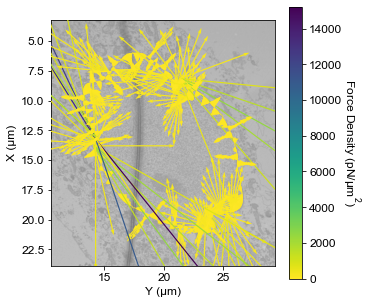

Processing 34D-grid3-ActA1_020_16


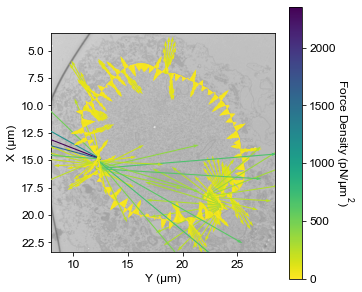

Processing 34D-grid3-s6_005_16


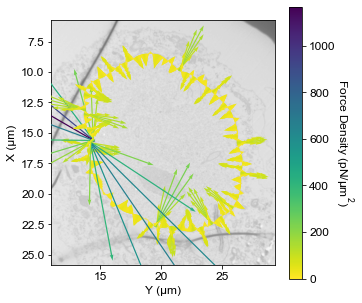

Processing 34D-grid2-s3_028_16


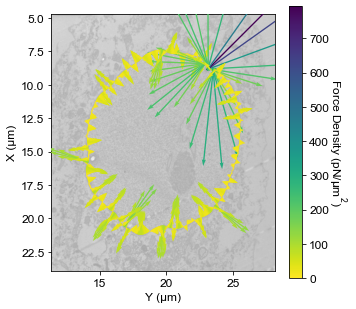

Processing 34D-grid3-ActA1_001_16


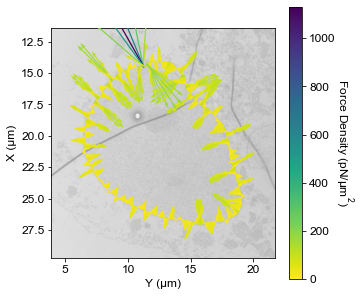

Processing 34D-grid3-ActA1_002_16


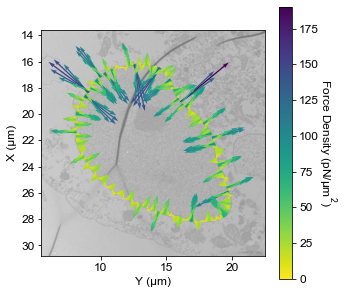

Processing 34D-grid3-ActA1_003_16


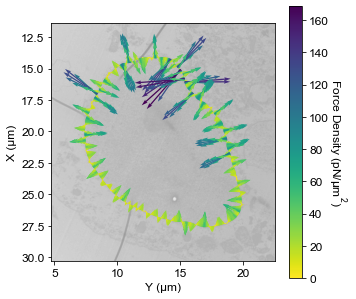

Processing 34D-grid3-ActA1_004_16


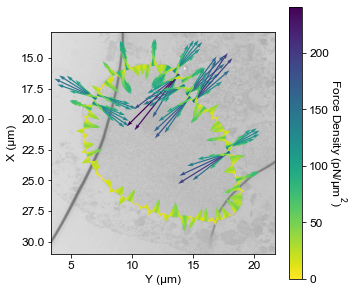

In [23]:
cm = mpl.cm.viridis_r
padding = 2  # padding to add around cell boundary to give broader image context

for file in files:
    k = file.stem
    d = data[k]
    print(f"Processing {k}")

    original_coords = d["original_coords"]
    relaxed_coords = d["relaxed_coords"]
    forces = d["relaxed_forces"]
    dualLengths = d["dualLengths"]
    f_mag = np.linalg.norm(forces, axis=1)

    norm = mpl.colors.Normalize(vmin=f_mag.min(), vmax=f_mag.max())
    # Map values to colors and add vertex color layer
    colors = cm(norm(f_mag))

    # with Image.open(f"crop_images/{k}.png") as im:
    with Image.open(f"raw_images/{k}.TIF") as im:
        pixel_scale = images[k]

        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        # ax.plot(original_coords[:, 0], original_coords[:, 1], color="r")
        # ax.plot(relaxed_coords[:, 0], relaxed_coords[:, 1], color="gray", zorder=1)

        Q = ax.quiver(
            relaxed_coords[:, 0],
            relaxed_coords[:, 1],
            forces[:, 0],
            forces[:, 1],
            f_mag,
            cmap=cm,
            angles="xy",
            units="xy",
            label="force",
            scale=4e1,
            scale_units="xy",
            width=0.1,
            zorder=10,
        )
        ax.set_ylabel(r"X (μm)")
        ax.set_xlabel(r"Y (μm)")

        x_lim = np.array(ax.get_xlim()) + [-padding, padding]
        y_lim = np.array(ax.get_ylim()) + [-padding, padding]

        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)

        x_lim_pix = (x_lim / pixel_scale).round()
        y_lim_pix = (y_lim / pixel_scale).round()

        ax.set_ylim(ax.get_ylim()[::-1])

        im = im.crop((x_lim_pix[0], y_lim_pix[0], x_lim_pix[1], y_lim_pix[1]))

        plt.imshow(
            im,
            alpha=0.6,
            extent=(x_lim[0], x_lim[1], y_lim[1], y_lim[0]),
            zorder=0,
            cmap=plt.cm.Greys_r,
        )

        # Shrink current axis
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cm), ax=ax)
        cbar.ax.get_yaxis().labelpad = 20
        cbar.ax.set_ylabel("Force Density ($\mathregular{pN/\mu m^2}$)", rotation=270)

        # Quiver key draws length of arrow
        # qk = ax.quiverkey(Q, 0.45, 0.8, 500, r'$500 \frac{pN}{\mu m^2}$', labelpos='E', coordinates='figure')

        plt.savefig(f"figures/{file.stem}_force.pdf")
        plt.show()


Processing 34D-grid2-s3-acta1_001_16


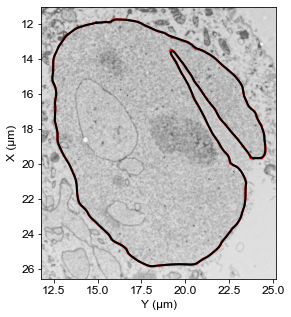

Processing 34D-grid3-ActA1_007_16


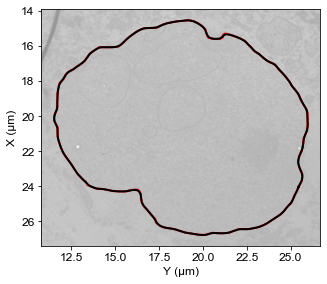

Processing 34D-grid3-ActA1_013_16


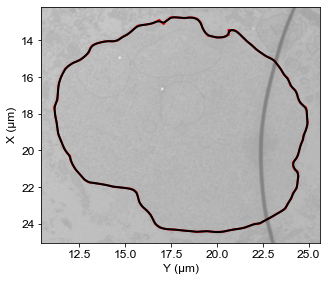

Processing 34D-grid2-s2_002_16


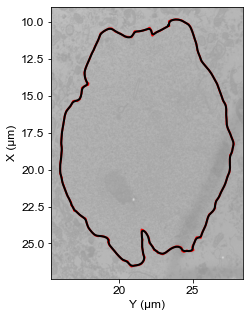

Processing 34D-grid2-s5_005_16


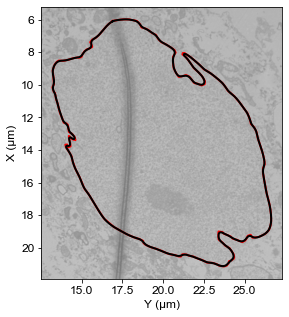

Processing 34D-grid3-ActA1_020_16


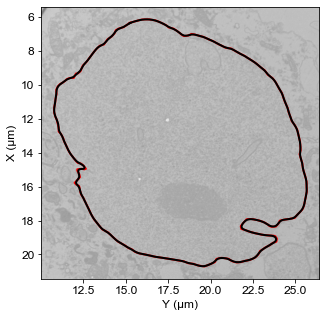

Processing 34D-grid3-s6_005_16


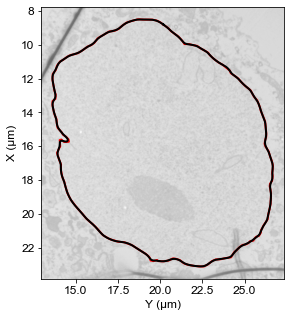

Processing 34D-grid2-s3_028_16


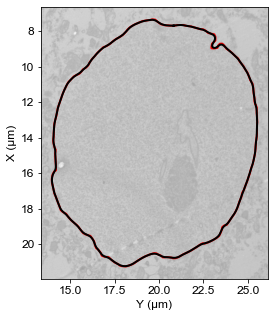

Processing 34D-grid3-ActA1_001_16


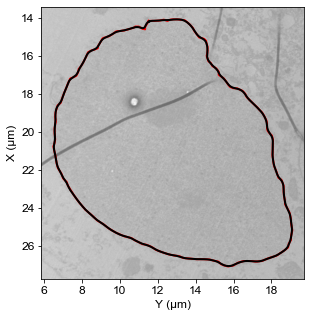

Processing 34D-grid3-ActA1_002_16


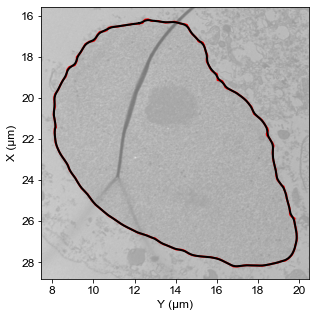

Processing 34D-grid3-ActA1_003_16


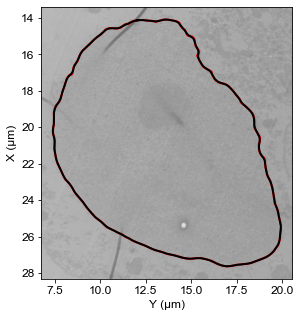

Processing 34D-grid3-ActA1_004_16


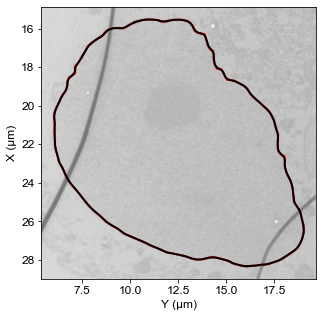

In [17]:
cm = mpl.cm.viridis_r

for file in files:
    k = file.stem
    d = data[k]
    print(f"Processing {k}")

    original_coords = d["original_coords"]
    relaxed_coords = d["relaxed_coords"]
    forces = d["relaxed_forces"]
    dualLengths = d["dualLengths"]
    f_mag = np.linalg.norm(forces, axis=1)

    norm = mpl.colors.Normalize(vmin=f_mag.min(), vmax=f_mag.max())
    # Map values to colors and add vertex color layer
    colors = cm(norm(f_mag))

    # with Image.open(f"crop_images/{k}.png") as im:
    with Image.open(f"raw_images/{k}.TIF") as im:
        pixel_scale = images[k]

        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

        ax.plot(original_coords[:, 0], original_coords[:, 1], color="r")
        ax.plot(relaxed_coords[:, 0], relaxed_coords[:, 1], color="k", zorder=10)
        ax.set_ylabel(r"X (μm)")
        ax.set_xlabel(r"Y (μm)")

        x_lim = np.array(ax.get_xlim())
        y_lim = np.array(ax.get_ylim())

        x_lim_pix = (x_lim / pixel_scale).round()
        y_lim_pix = (y_lim / pixel_scale).round()

        ax.set_ylim(ax.get_ylim()[::-1])

        im = im.crop((x_lim_pix[0], y_lim_pix[0], x_lim_pix[1], y_lim_pix[1]))

        plt.imshow(
            im, alpha=0.6, extent=(x_lim[0], x_lim[1], y_lim[1], y_lim[0]), zorder=0, cmap = plt.cm.Greys_r
        )

        # Shrink current axis
        # box = ax.get_position()
        # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        # cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cm), ax=ax)
        # cbar.ax.get_yaxis().labelpad = 20
        # cbar.ax.set_ylabel("Force Density ($\mathregular{pN/\mu m^2}$)", rotation=270)

        plt.savefig(f"figures/{file.stem}_force.pdf")
        plt.show()


In [18]:
for file in files:
    k = file.stem
    d = data[k]

    original_coords = d["original_coords"]
    relaxed_coords = d["relaxed_coords"]
    forces = d["relaxed_forces"]
    dualLengths = d["dualLengths"]

    print(
        "Mean dual length:",
        np.mean(dualLengths),
        "μm;",
        np.mean(dualLengths) ** 2,
        "μm^2",
    )


Mean dual length: 0.04942003 μm; 0.0024423392589421056 μm^2
Mean dual length: 0.049480658 μm; 0.0024483355185424133 μm^2
Mean dual length: 0.04919061 μm; 0.0024197161758445773 μm^2
Mean dual length: 0.048269175 μm; 0.002329913254508542 μm^2
Mean dual length: 0.047996555 μm; 0.0023036692461471248 μm^2
Mean dual length: 0.048890926 μm; 0.002390322639647169 μm^2
Mean dual length: 0.049103007 μm; 0.002411105268997682 μm^2
Mean dual length: 0.049093492 μm; 0.0024101709890694267 μm^2
Mean dual length: 0.04919533 μm; 0.002420180551860343 μm^2
Mean dual length: 0.048993748 μm; 0.0024003873118666613 μm^2
Mean dual length: 0.049303785 μm; 0.002430863212019796 μm^2
Mean dual length: 0.04937545 μm; 0.002437934902325148 μm^2


Assuming an actin filament is ~7nm in diameter a conservative surface area occupancy is 49 $\mathrm{nm^2}$ or 4.9e-5 $\mathrm{\mu m^2}$. Depending on cell conditions a single actin filament can produce ~1 pN of force.

Then 1pN * A / 4.9e-5 μm^2 gives the maximum force assuming full surface coverage by pushing actin.


